## New Section

In [ ]:
#-> Importing_google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install TPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.8 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* **---------------------- 1. Detecting distinctive keypoints ----------------------**


 ----------------------import the necessary libraries.----------------------

In [ ]:
import sys
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

* To achieve more accurate results we will load our two images as a grayscale.

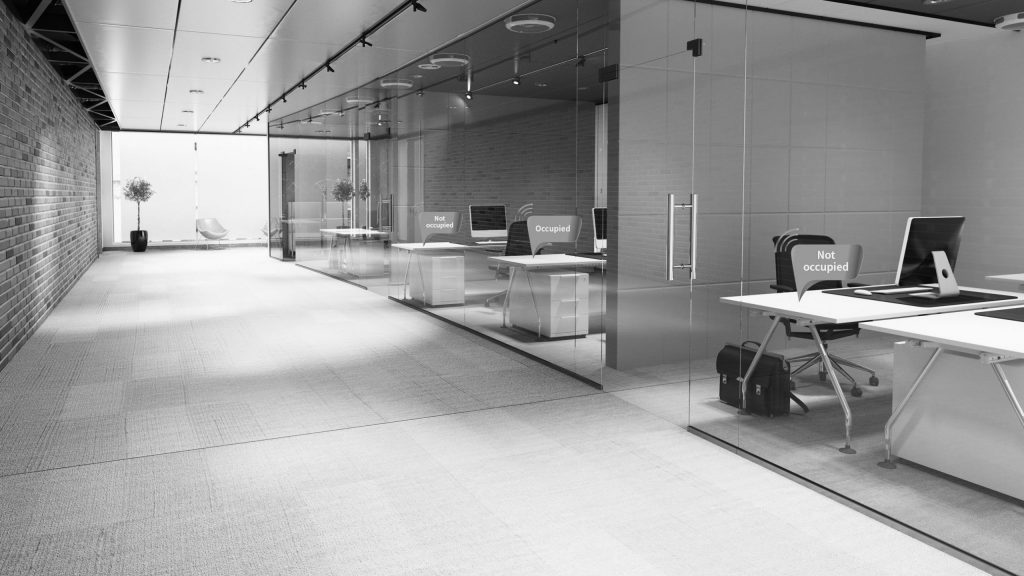

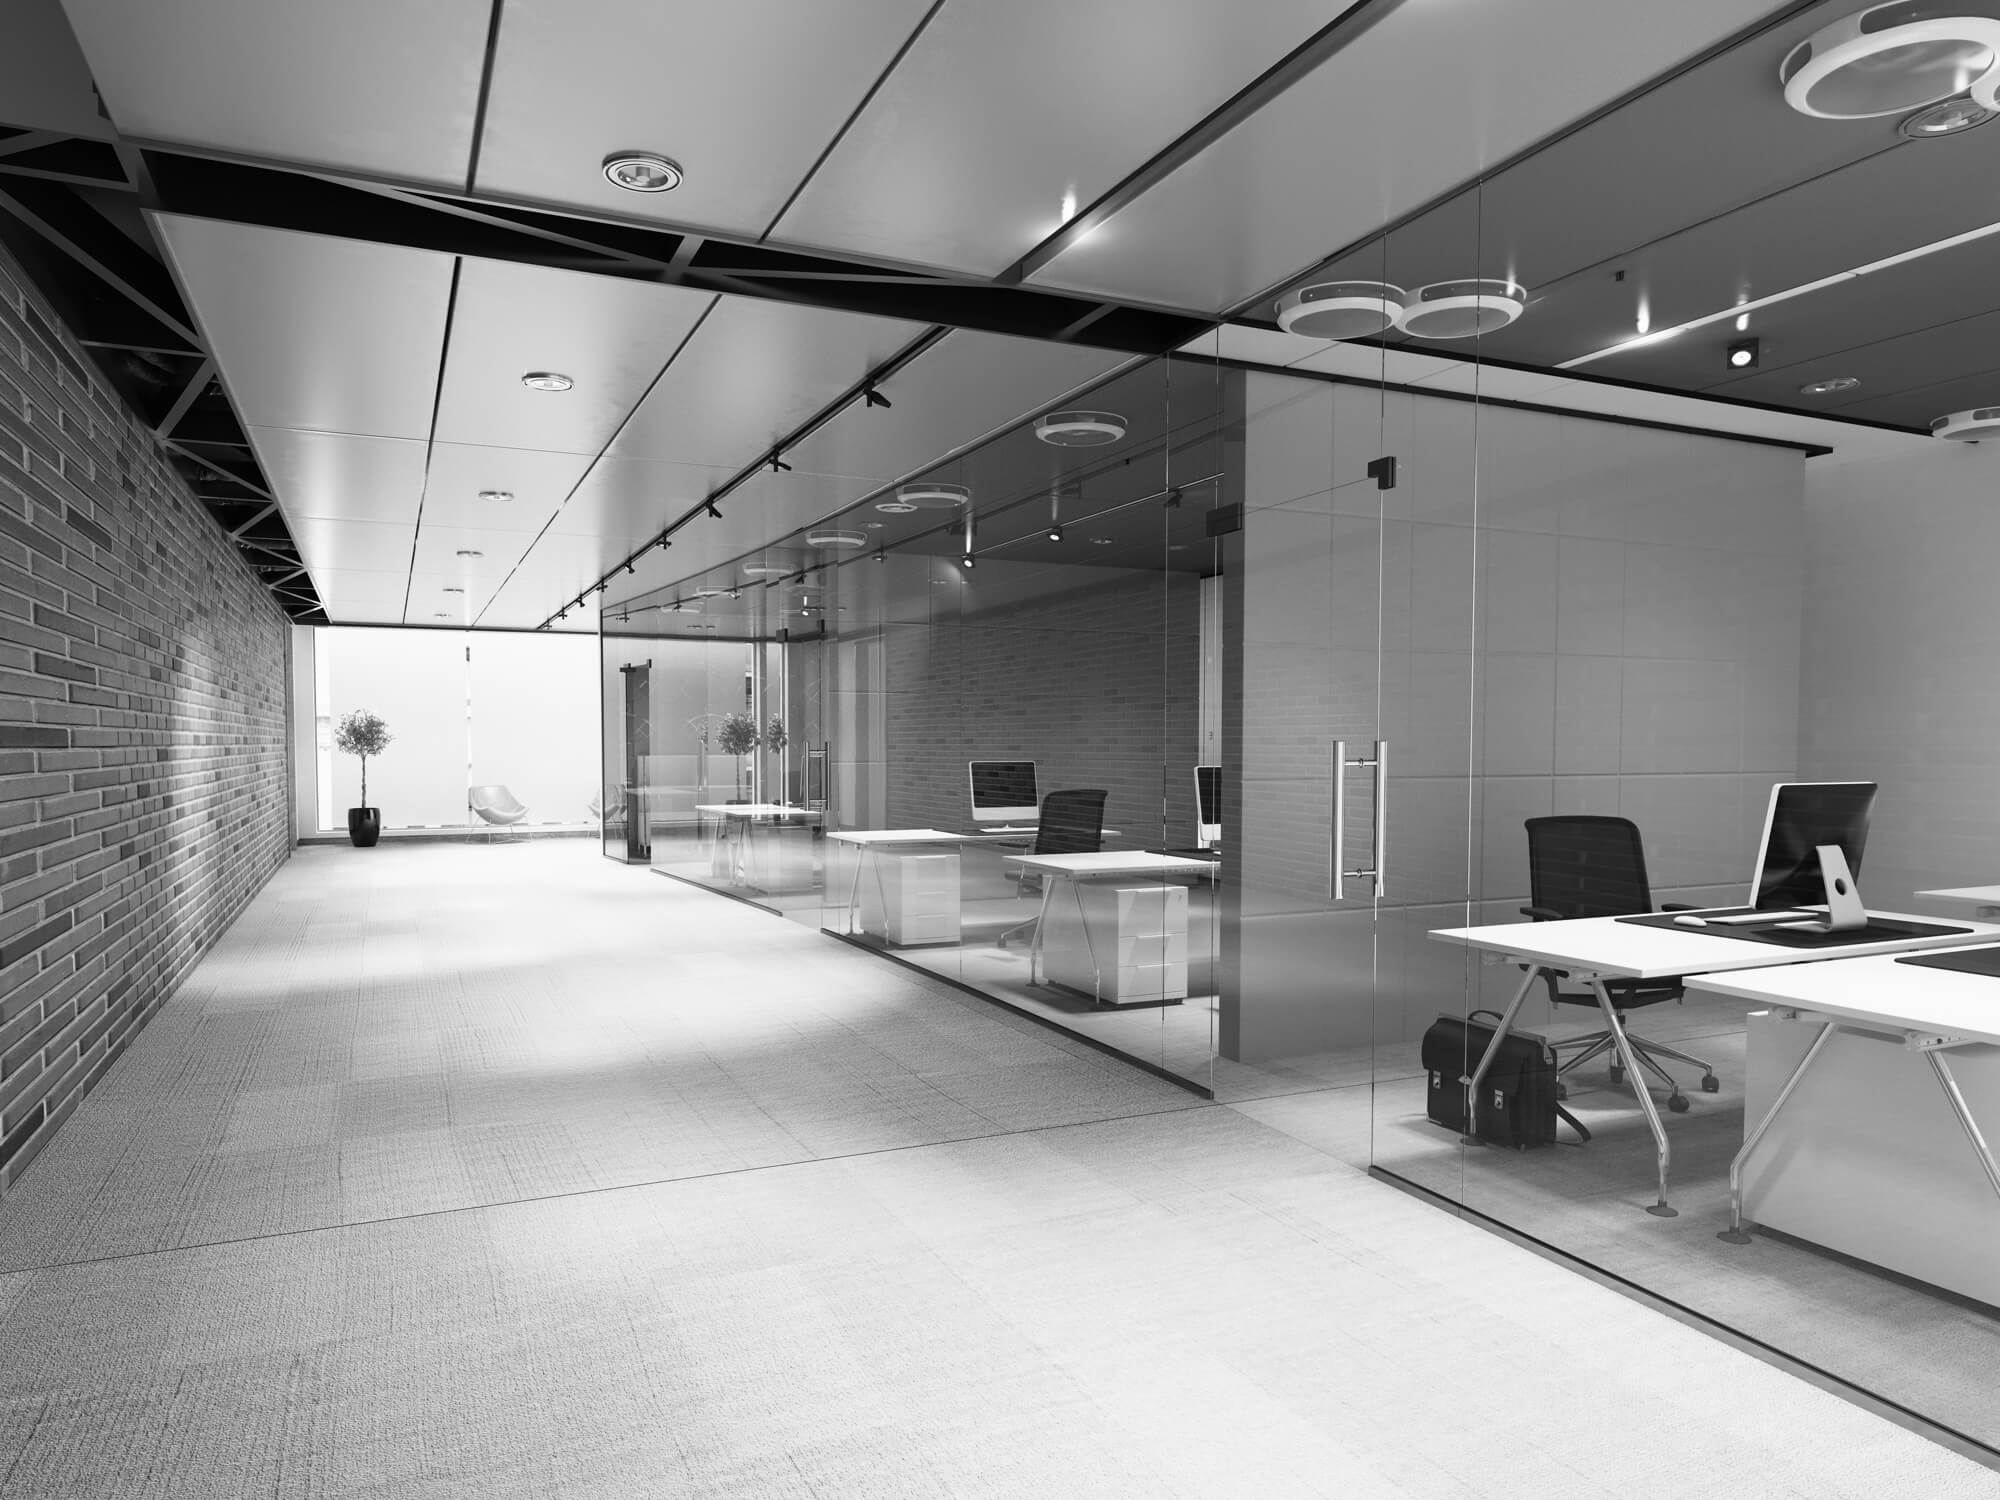

In [ ]:
# Load our images
img1 = cv2.imread("/content/1.jpg")
img2 = cv2.imread("/content/2.jpg")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

cv2_imshow(img1_gray)
cv2_imshow(img2_gray)

In [ ]:
# Create our ORB detector and detect keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

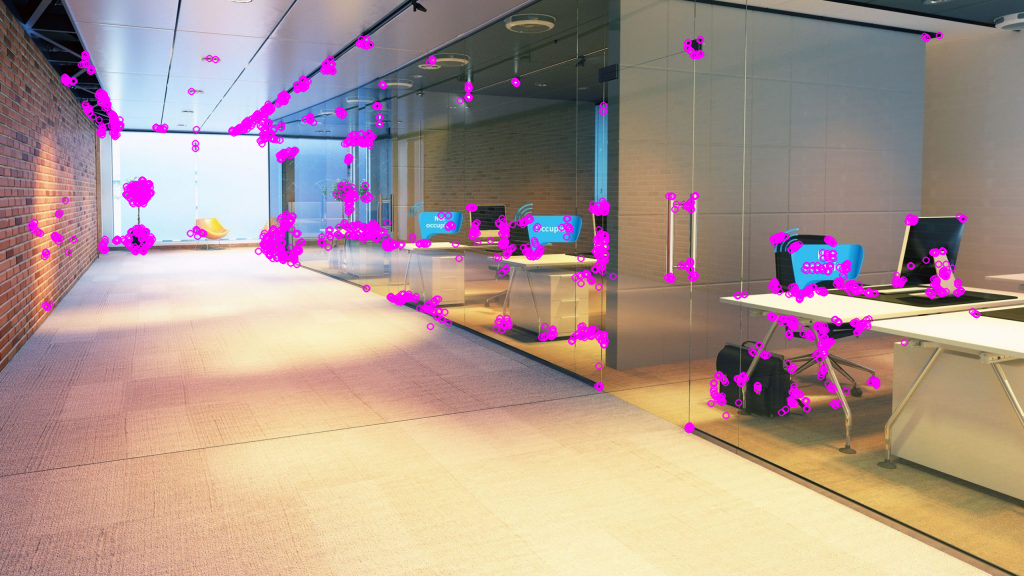

In [ ]:
cv2_imshow(cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255)))

In [ ]:
cv2_imshow(cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255)))

* **---------------------- 2. Matching the points between two images ----------------------**

In [ ]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2,k=2)

In [ ]:
#_Let’s take a closer look at one keypoint in order to see how its structure looks like. First, we can see it’s (x,y) position using the .pt argument.
print(keypoints1[0].pt)

(280.0, 219.0)


In [ ]:
#_Also, we can see its size using the .size argument
print(keypoints1[0].size)

31.0


In [ ]:
#_Now, let’s print the descriptor of a first point.
print("Descriptor of the first keypoint: ")
print(descriptors1[0])

Descriptor of the first keypoint: 
[  9  42 202 145  53 184 249  19 127  69 118 144 175 128 211 236  75 168
 238  29 150 252 229 192 206 255 146  65 198 141  89 196]


In [ ]:
#_We can also print the distance between the first keypoint in the first image and the first kaypoint in the second image.
#_print(matches_sorted[0].distance)

* Now, let’s continue with our post. The next step is to define function draw_matches() that will be used to match overlapping keypoints. This function consists of the following parameters.

1. * img1, img2 – the input images
2. * keypoints1 – keypoints detected in the first image
3. * keypoints2 – keypoins detected in the second image
4. * matches – overlapping keypoins

In [ ]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r, c = img1.shape[:2]
  r1, c1 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
  output_img[:r, :c, :] = np.dstack([img1, img1, img1])
  output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

  # Go over all of the matching points and extract them
  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
    cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)
    
  return output_img


* Now, using the function draw_matches()we can draw matching points in the image. For better visualization, we will draw only the first 30 matches.

In [ ]:
all_matches = []
for m, n in matches:
  all_matches.append(m)

img3 = draw_matches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:30])
cv2_imshow(img3)

In [ ]:
# Finding the best matches
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

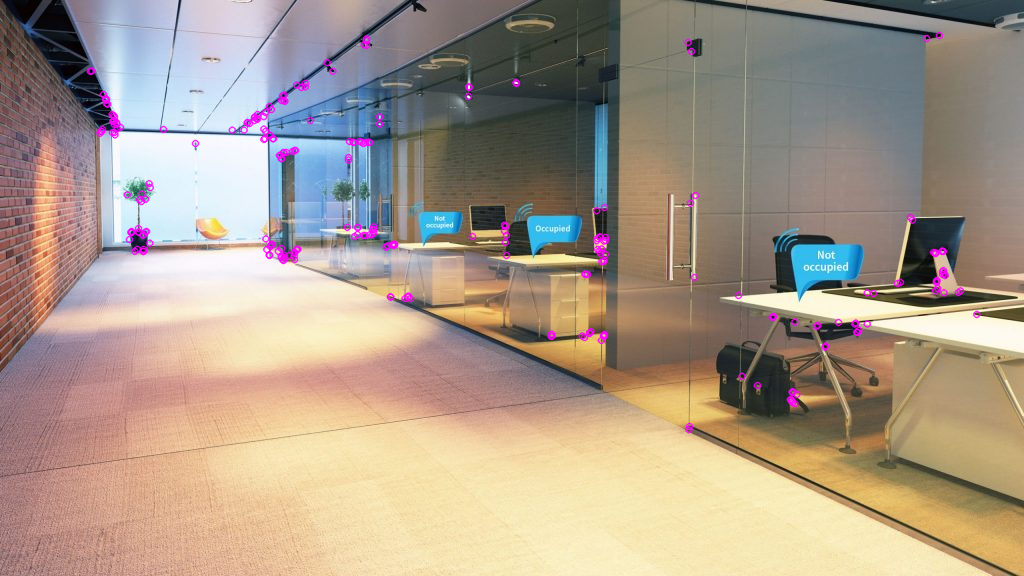

In [ ]:
cv2_imshow(cv2.drawKeypoints(img1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255)))

In [ ]:
cv2_imshow(cv2.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (255, 0, 255)))

* **---------------------- 3. Stitching two images together ----------------------**

In [ ]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

In [ ]:
# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)

    cv2_imshow(result)